# DATOS

En este bloque se realiza la importacion y analisis de datos, dividimos los datos para el entrenamiento tambien, y una visualizacion para tener una vista sin muchoi detalle con los datos que vamos a estar trabajando.

Se implemento tambien el agregado de una columna "code" que incluye el codigo del estado de la fila con el fin de poder graficar por estado el nivel de seguridad.

In [1]:
# Import de bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Cargamos el dataframe y separamos en la variable X los valores de entrenamiento
df = pd.read_csv("Crimenes.csv")
X = df[['Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones']]

In [2]:
# Cargamos un dataset con los estados y sus codigos
fips_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

# Buscamos los estados en nuestro dataframe, extraemos el codigo de el otro dataframe y agregamos a una nueva columna
df['code'] = df['Estado'].map(fips_codes.set_index('state')['code'])
df.head()

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,code
0,Alabama,13.2,236,58,21.2,AL
1,Alaska,10.0,263,48,44.5,AK
2,Arizona,8.1,294,80,31.0,AZ
3,Arkansas,8.8,190,50,19.5,AR
4,California,9.0,276,91,40.6,CA


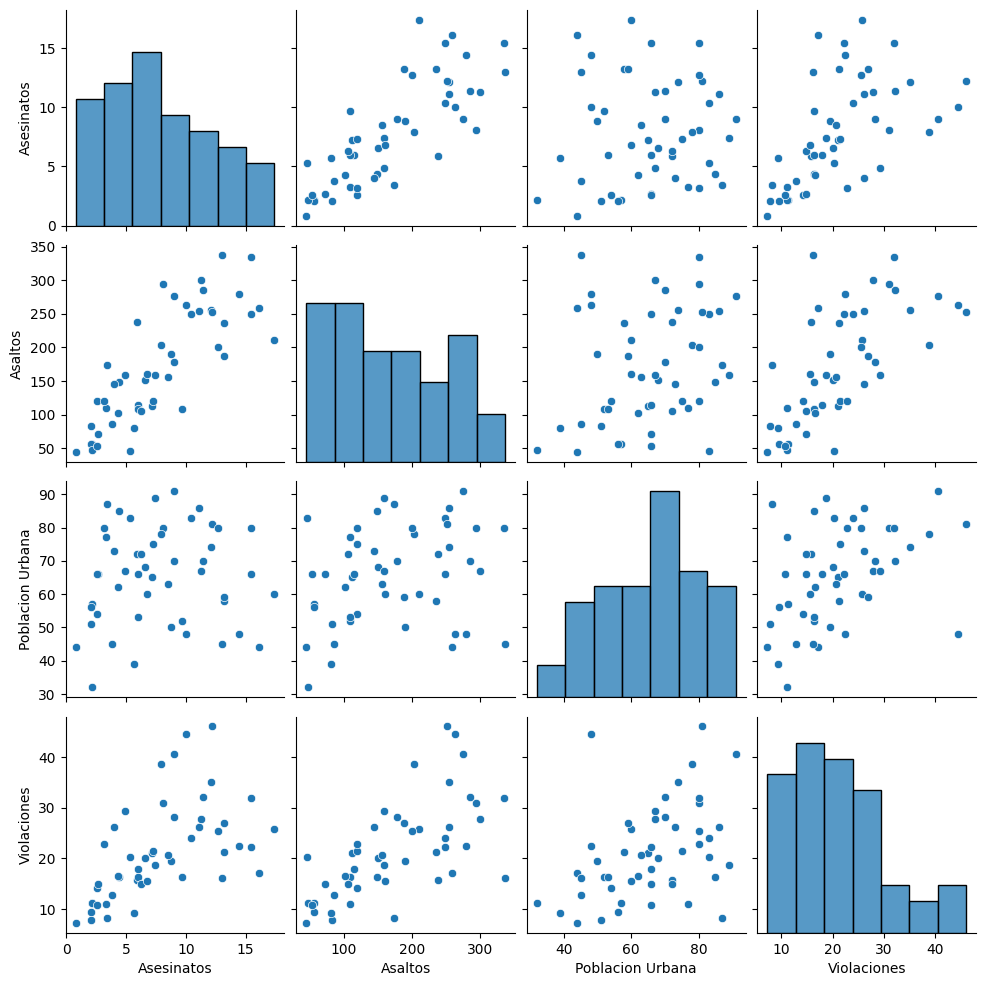

In [3]:
# Creamos una matriz de graficos y mostramos los mismos
sns.pairplot(X)
plt.show()

# KMEANS

En este bloque realizamos el clustering utilizando KMeans, iniciamos buscando el valor ideal para el numero de clusters utilizando el metodo del codo, analizando el grafico deducimos que el valor idoneo es 3 (Para este tipo de modelo), luego realizamos la visualizacion de los datos con los centroides (Unicamente la relacion Asesinatos / Asaltos ya que no se pueden visualizar mas de 3 dimensiones), luego la matriz de datos separados por color para ver la distribucion de nuestros datos y finalmente agragamos la columna del codigo de estado a cada fila para poder graficar en un mapa los estados mas seguros.

c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

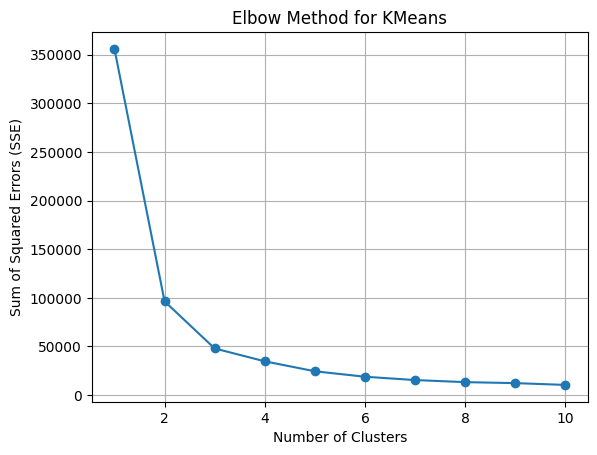

In [4]:
# Inicializamos una lista vacia para guardar los valores obtenidos
sse = []

# Iteramos en un rango de 1 a 11
for k in range(1, 11):

    # Creamos un modelo Kmeans y entrenamos con la cantidad de clusters de la iteracion
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X)

    # Guardamos el "score" del modelo en la lista
    sse.append(kmeans.inertia_)

# Graficamos los diferentes "scores" obtenidos, -> Metodo del Codo
plt.plot(range(1, 11), sse, marker='o')

# Extras del grafico
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



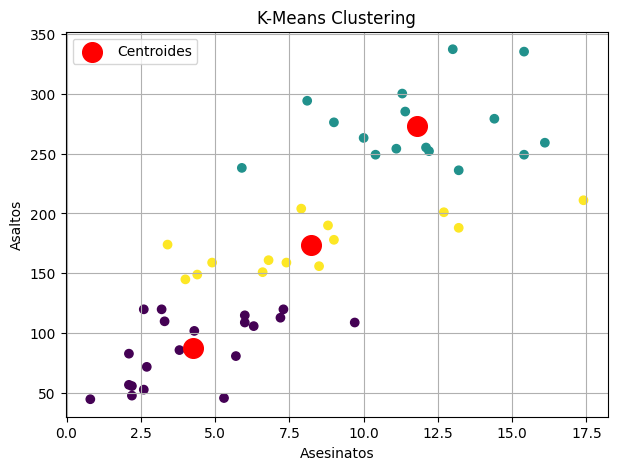

In [13]:
# Creamos el modelo con los clusters obtenidos del grafico (3) y entrenamos
kmeans = KMeans(n_clusters = 3, random_state = 42)
clusters = kmeans.fit_predict(X)

# Medida del grafico
plt.figure(figsize = (7, 5))

# Graficamos la relacion asesinatos y asaltos, diferenciandolos por su cluster
plt.scatter(X['Asesinatos'], X['Asaltos'], c = clusters, cmap = 'viridis')

# Graficamos los centroides de cada cluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'red', marker = 'o', label = 'Centroides')

# Extras del grafico
plt.xlabel('Asesinatos')
plt.ylabel('Asaltos')
plt.title('K-Means Clustering')
plt.grid(True)
plt.legend()
plt.show()

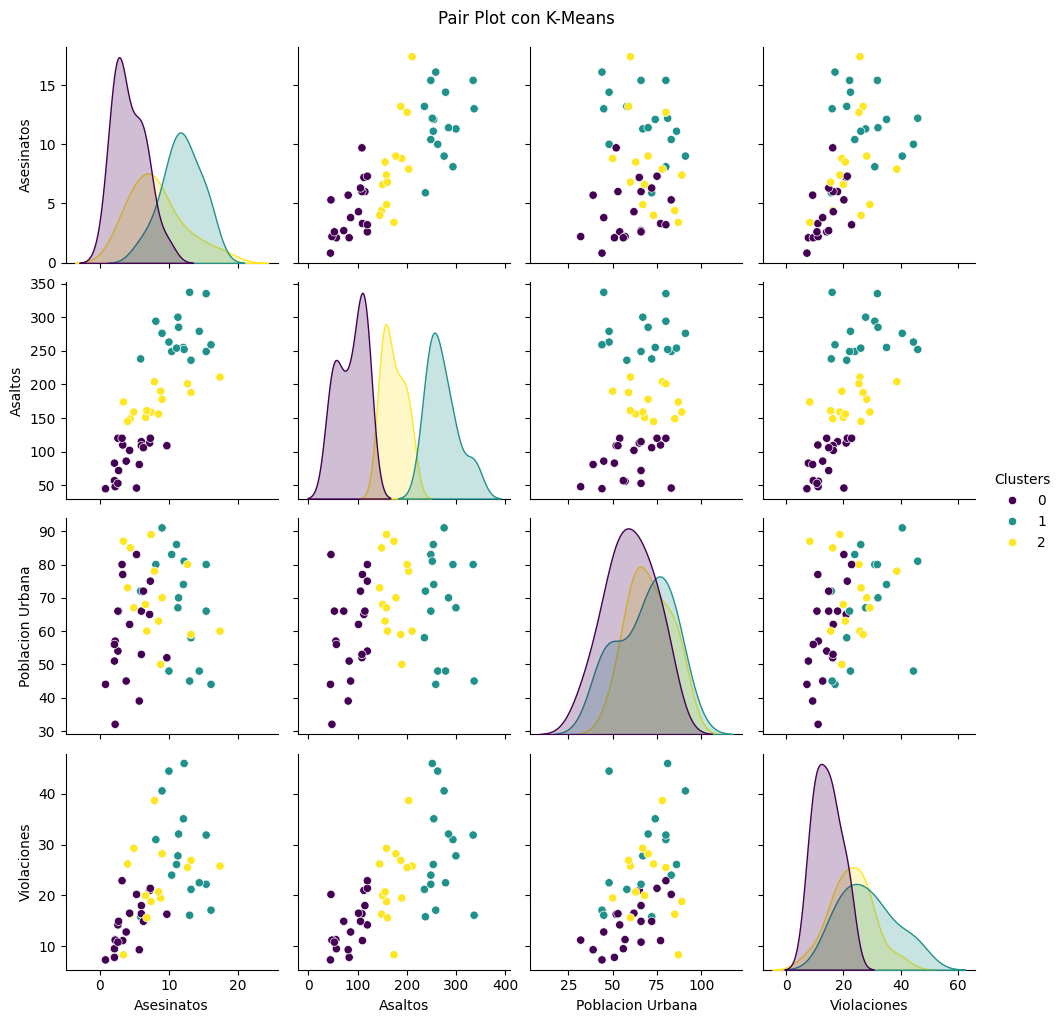

In [8]:
# Copiamos el datafame X y le insertamos una columna que conenga el cluster de cada estado
XKmeans = X.copy()
XKmeans["Clusters"] = clusters

# Creamos una matriz de graficos y mostramos los mismos
sns.pairplot(XKmeans, hue = 'Clusters', palette = 'viridis')
plt.suptitle('Pair Plot con K-Means', y = 1.02)
plt.show()

In [9]:
# Extraemos la columna con los codigos de estado de el dataframe DF y guardamos en una nueva columna
XKmeans["Estado"] = df["code"]

# Creamos una nueva columna "Seguridad" que compare el valor que tiene cada fila de la columna Clusters y le agregue un valor a la nueva columna
mapeo_etiquetas = {0: 'Seguro', 1: 'Peligroso', 2: 'Alerta'}
XKmeans['Seguridad'] = XKmeans['Clusters'].map(mapeo_etiquetas)
XKmeans.head()

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,Clusters,Estado,Seguridad
0,13.2,236,58,21.2,1,AL,Peligroso
1,10.0,263,48,44.5,1,AK,Peligroso
2,8.1,294,80,31.0,1,AZ,Peligroso
3,8.8,190,50,19.5,2,AR,Alerta
4,9.0,276,91,40.6,1,CA,Peligroso


In [11]:
# Creamos un grafico de mapa
fig = px.choropleth(
    XKmeans,    # DataFrame
    locations = 'Estado',   # Columna con codigos de estado
    locationmode = 'USA-states',
    color = 'Seguridad',    # Columna con los clusters (clusters con str para mejor visualizacion)
    scope = 'usa',
    color_discrete_sequence = ["red", "yellow", "green"],   # Secuencia de colores a seguir
)

# Fijamos un titulo y graficamos
fig.update_layout(title_text = 'Mapa de Clusters')
fig.show()

# MEAN SHIFT

En este bloque realizamos el clustering utilizando Mean Shift, iniciamos buscando el valor ideal para el ancho de banda utilizando la funcion "estimate_bandwidth" y probamos con distintaos datos y luego graficamos con los distintos puntajes obtenidos, analizando el grafico deducimos que el valor idoneo para ancho de banda es 90 , luego realizamos la visualizacion de los datos con los centroides (Unicamente la relacion Asesinatos / Asaltos ya que no se pueden visualizar mas de 3 dimensiones), luego la matriz de datos separados por color para ver la distribucion de nuestros datos y finalmente agragamos la columna del codigo de estado a cada fila para poder graficar en un mapa los estados mas seguros.

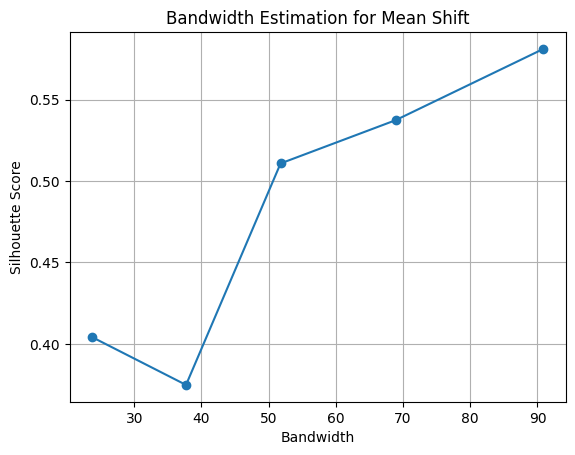

In [12]:
# Inicializamos listas vacias para almacenar datos luego
bandwidths = []
silhouettes = []

# Creamos una lista que inicie en 0.1 hasta 0.6 con un paso de 0.1
quantiles = np.arange(0.1, 0.6, 0.1)

# Iteramos en cada uno de los valores de la lista "quantiles"
for quantile in quantiles:

    # Estima el ancho de banda con el valor de quantile actual y guarda en la lista
    bandwidth = estimate_bandwidth(X, quantile = quantile)
    bandwidths.append(bandwidth)

    # Creamos un modelo de MeanShift con el ancho de banda indicado y entrenamos
    ms = MeanShift(bandwidth = bandwidth).fit(X)

    # Verificamos si hay mas de un cluster
    if len(np.unique(ms.labels_)) > 1:
        # Calcula el puntaje y guardamos en una lista
        sil_score = silhouette_score(X, ms.labels_)
        silhouettes.append(sil_score)

    # Si no hay mas de 1 cluster
    else:
        # Asignamos un puntaje de -1
        silhouettes.append(-1)

# Graficamos la relacion de ancho de banda con los puntajes para visualizar el mejor
plt.plot(bandwidths, silhouettes, 'o-')

# Extras del grafico
plt.xlabel("Bandwidth")
plt.ylabel("Silhouette Score")
plt.title("Bandwidth Estimation for Mean Shift")
plt.grid(True)
plt.show()


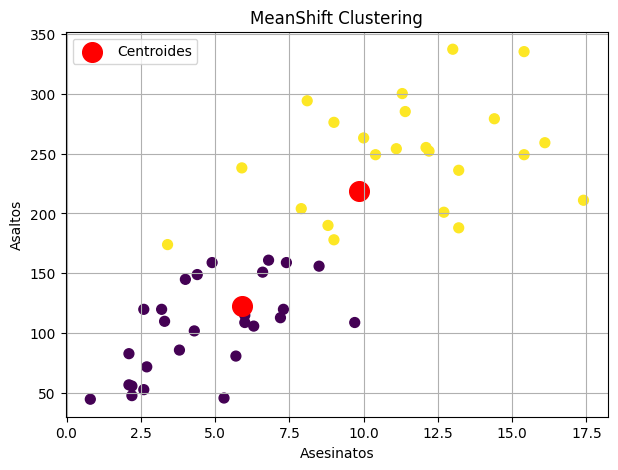

In [14]:
# reamos el modelo con el ancho de banda con mejor "score" y entrenamos
MShift = MeanShift(bandwidth = 90).fit(X)
labels = MShift.labels_

# Medida del grafico
plt.figure(figsize=(7, 5))

# Graficamos la relacion asesinatos y asaltos, diferenciandolos por su cluster
plt.scatter(X["Asesinatos"], X["Asaltos"], c = labels, s = 50, cmap='viridis')

# Graficamos los centroides de cada cluster
plt.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1], s = 200, c = 'red', marker = 'o', label = 'Centroides')

# Extras del grafico
plt.title(f'MeanShift Clustering')
plt.xlabel('Asesinatos')
plt.ylabel('Asaltos')
plt.grid(True)
plt.legend()
plt.show()

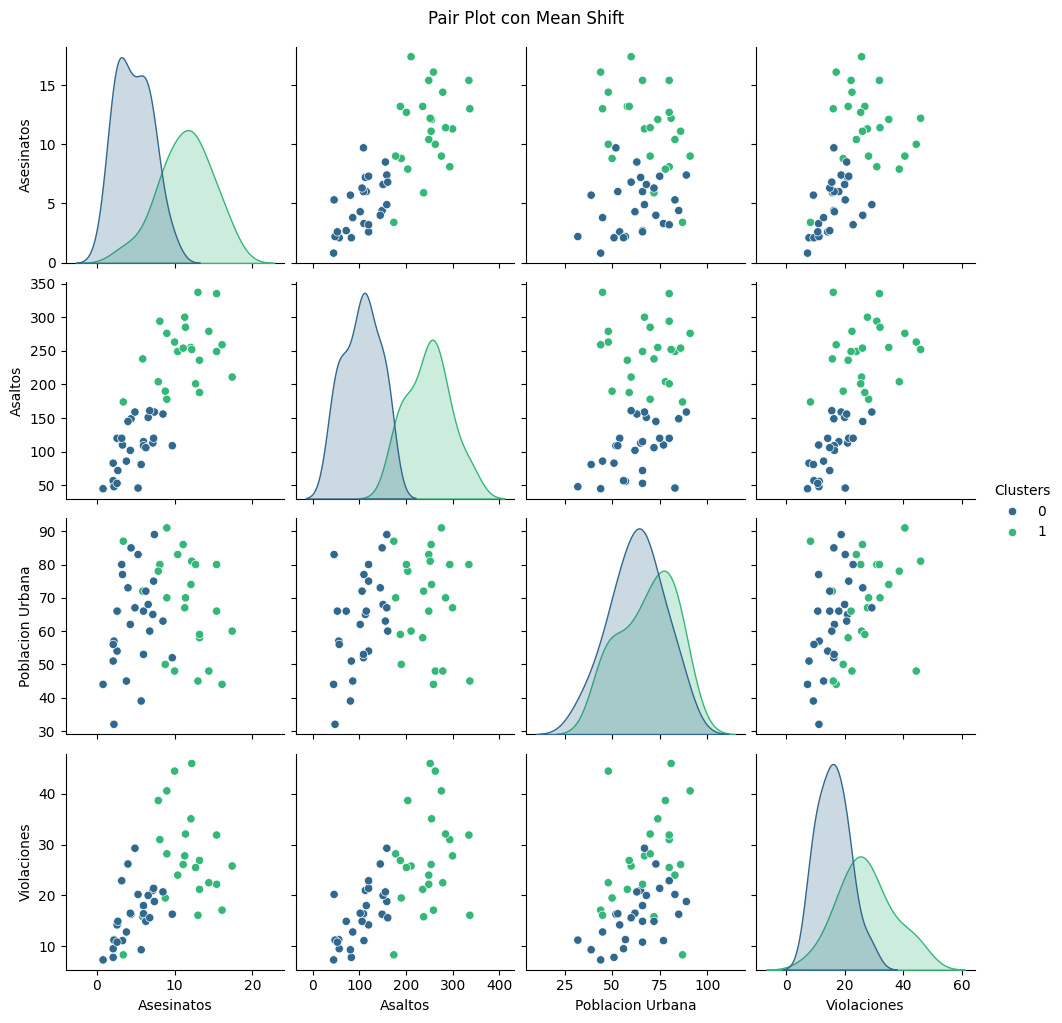

In [15]:
# Copiamos el datafame X y le insertamos una columna que conenga el cluster de cada estado
XMShift = X.copy()
XMShift["Clusters"] = labels

# Creamos una matriz de graficos y mostramos los mismos
sns.pairplot(XMShift, hue='Clusters', palette='viridis')
plt.suptitle('Pair Plot con Mean Shift', y=1.02)
plt.show()

In [17]:
# Extraemos la columna con los codigos de estado de el dataframe DF y guardamos en una nueva columna
XMShift["Estado"] = df["code"]

# Creamos una nueva columna "Seguridad" que compare el valor que tiene cada fila de la columna Clusters y le agregue un valor a la nueva columna
mapeo_etiquetas = {0: 'Seguro', 1: 'Peligroso'}
XMShift['Seguridad'] = XMShift['Clusters'].map(mapeo_etiquetas)
XMShift.head()

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,Clusters,Estado,Seguridad
0,13.2,236,58,21.2,1,AL,Peligroso
1,10.0,263,48,44.5,1,AK,Peligroso
2,8.1,294,80,31.0,1,AZ,Peligroso
3,8.8,190,50,19.5,1,AR,Peligroso
4,9.0,276,91,40.6,1,CA,Peligroso


In [18]:
# Creamos un grafico de mapa
fig = px.choropleth(
    XMShift,    # DataFrame
    locations='Estado',     # Columna con codigos de estado
    locationmode='USA-states',
    color='Seguridad',      # Columna con los clusters (clusters con str para mejor visualizacion)
    scope='usa',
    color_discrete_sequence=["red", "green"],   # Secuencia de colores a seguir
)

# Fijamos un titulo y graficamos
fig.update_layout(title_text='Mapa de Clusters')
fig.show()

# DBSCAN

En este bloque realizamos el clustering utilizando DBScan, iniciamos buscando el valor ideal para el parametro ESP, analizando el grafico deducimos que el valor idoneo para este es 27 (Fuimos probando manualmente hasta encontrar un resultado que nos gusto) , luego realizamos la visualizacion de los datos con los centroides (Unicamente la relacion Asesinatos / Asaltos ya que no se pueden visualizar mas de 3 dimensiones), luego la matriz de datos separados por color para ver la distribucion de nuestros datos y finalmente agragamos la columna del codigo de estado a cada fila para poder graficar en un mapa los estados mas seguros.

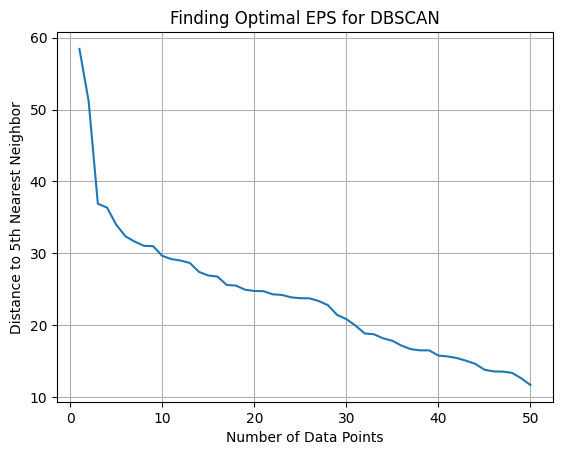

In [20]:
# Inicializamos un modelo para que busque los 5 vecinos mas cercanos y entrenamos
nn = NearestNeighbors(n_neighbors = 5)
nbrs = nn.fit(X)

# Obtenemos las distancias y los indices de los 5 vecinos más cercanos para cada punto
distances, indices = nbrs.kneighbors(X)

# Seleccionamos las distancias al quinto vecino mas cercano, las ordena en orden descendente
distanceDec = sorted(distances[:, 5-1], reverse=True)

# Graficamos para viusualizar las distancias al 5to vecino mas cercano
plt.plot(list(range(1, len(distanceDec) + 1)), distanceDec)

# Extras del grafico
plt.xlabel("Number of Data Points")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.title("Finding Optimal EPS for DBSCAN")
plt.grid(True)
plt.show()

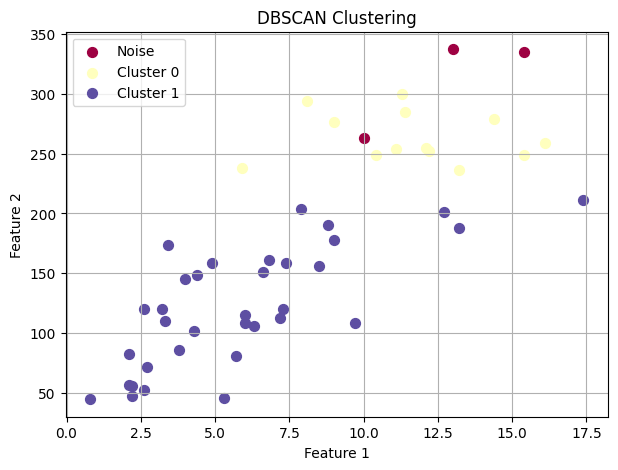

In [21]:
# Creamos el modelo con los datos obtenidos del grafico y entrenamos
db = DBSCAN(eps=27, min_samples=5).fit(X)
labels = db.labels_

# Medida del grafico
plt.figure(figsize=(7, 5))

# Obtenemos etiquetas unicas y colores para cada cluster
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# Iteramos sobre las etiquetas y colores para visualizar cada clúster
for (label, color) in zip(unique_labels, colors):

    # Filtramos los puntos pertenecientes al cluster actual
    class_member_mask = (labels == label)
    xy = X[class_member_mask]

    # Graficamos los puntos del cluster actual
    plt.scatter(xy["Asesinatos"], xy["Asaltos"], s=50, color=color, label='Cluster {}'.format(label) if label != -1 else 'Noise')

# Extras del grafico
plt.title('DBSCAN Clustering')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.legend()
plt.show()

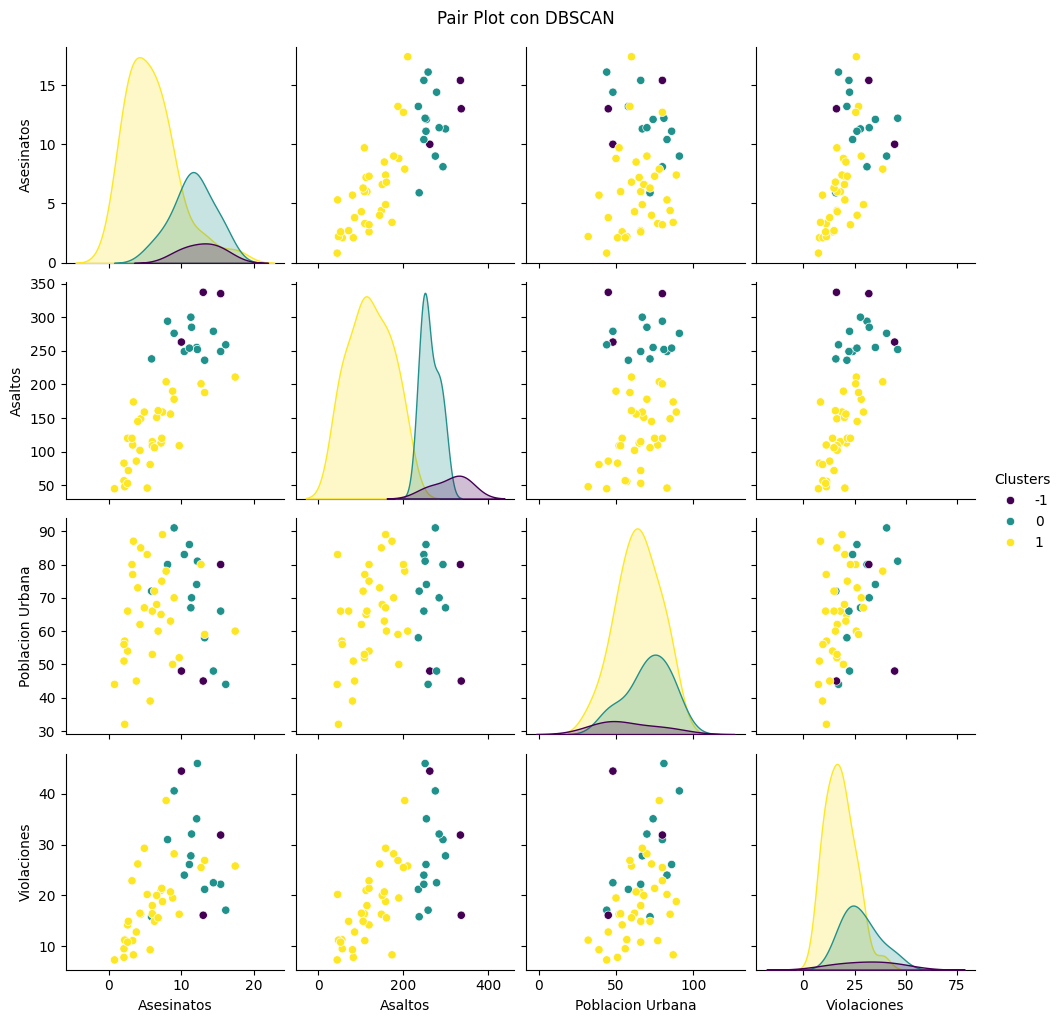

In [22]:
# Copiamos el datafame X y le insertamos una columna que conenga el cluster de cada estado
XDBScan = X.copy()
XDBScan["Clusters"] = labels

# Creamos una matriz de graficos y mostramos los mismos
sns.pairplot(XDBScan, hue='Clusters', palette='viridis')
plt.suptitle('Pair Plot con DBSCAN', y=1.02)
plt.show()

In [46]:
# Extraemos la columna con los codigos de estado de el dataframe DF y guardamos en una nueva columna
XDBScan["Estado"] = df["code"]
mapeo_etiquetas = {0: 'Peligroso', 1: 'Seguro', -1: 'Ruido'}

# Creamos una nueva columna "Seguridad" que compare el valor que tiene cada fila de la columna Clusters y le agregue un valor a la nueva columna
XDBScan['Seguridad'] = XDBScan['Clusters'].map(mapeo_etiquetas)
XDBScan.head()

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,Clusters,Estado,Seguridad
0,13.2,236,58,21.2,0,AL,Peligroso
1,10.0,263,48,44.5,-1,AK,Ruido
2,8.1,294,80,31.0,0,AZ,Peligroso
3,8.8,190,50,19.5,1,AR,Seguro
4,9.0,276,91,40.6,0,CA,Peligroso


In [48]:
# Creamos un grafico de mapa
fig = px.choropleth(
    XDBScan,    # DataFrame
    locations='Estado',     # Columna con codigos de estado
    locationmode='USA-states',      # Columna con los clusters (clusters con str para mejor visualizacion)
    color='Seguridad',
    scope='usa',
    color_discrete_sequence=["red", "violet", "green"],     # Secuencia de colores a seguir
)

# Fijamos un titulo y graficamos
fig.update_layout(title_text='Mapa de Clusters')
fig.show()